In [1]:
from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

In [35]:
channel = 2
orbit = 6434
#orbit = 22873
ir = open_level1_ir(orbit, channel, valid=False)
num2date(ir.mjd[0],units)

datetime.datetime(2002, 4, 29, 12, 1, 35, 573189)

## clip data


In [91]:
tan_alt = ir.l1.altitude
tan_lat = ir.l1.latitude
tan_lon = ir.l1.longitude
sc_look = ir.l1.look_ecef
sc_pos = ir.l1.position_ecef
l1 = ir.data
mjd = ir.mjd.data
pixel = ir.pixel.data

#====drop data below and above some altitudes
l1 = l1.where(tan_alt<110e3).where(tan_alt>60e3)

In [116]:
im_lst = np.arange(1400,2000,30)
pix_lst = np.arange(22, 128)

label_interval = 10

len(im_lst)

20

## altitude space plot

/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


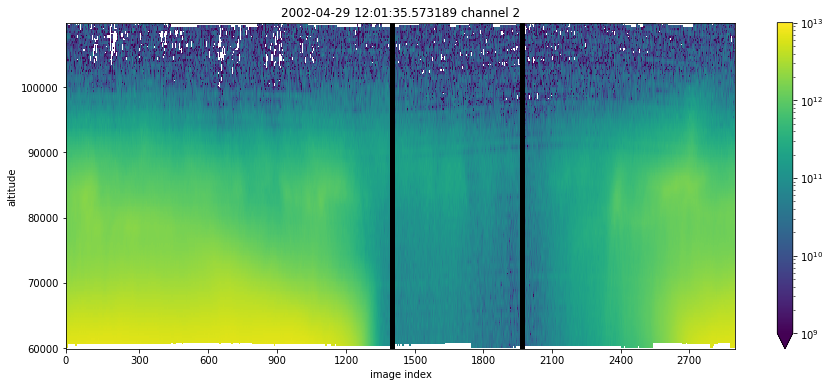

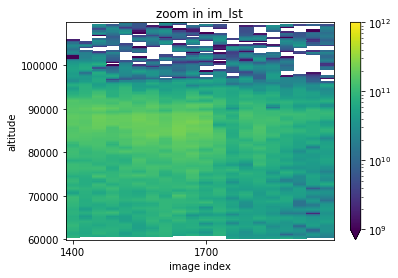

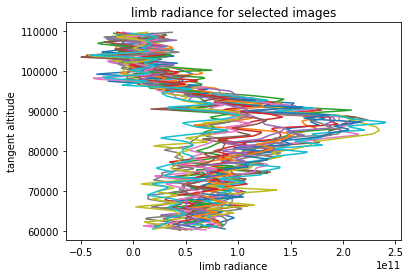

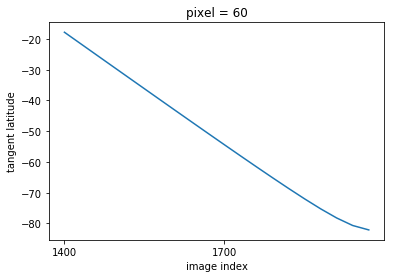

In [117]:
#%% interpolation 
alts_interp = np.arange(60e3, 110e3, .25e3)
data_interp = []


for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=[l1.mjd, alts_interp],
                           dims=['mjd', 'altitude'])

#%%plotting
plt.figure(figsize=(15,6))
data_interp.plot(x='mjd', y='altitude',
                 norm=LogNorm(), vmin=1e9, vmax=1e13)
plt.title(str(num2date(ir.mjd[0],units))+' channel '+str(channel))
plt.axvline(x=mjd[im_lst[0]], color='k', linewidth=5)
plt.axvline(x=mjd[im_lst[-1]], color='k', linewidth=5)
ax = plt.gca()
ax.set_xticks(mjd[np.arange(0,len(mjd),300, dtype=int)])
ax.set_xticklabels(np.arange(0,len(mjd),300))
ax.set(xlabel='image index')
plt.show()


plt.figure()
data_interp.isel(mjd=im_lst).plot(x='mjd', y='altitude', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e12)#, 
                 #size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst',
      xlabel='image index')
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
plt.show()

plt.figure()
plt.plot(data_interp.isel(mjd=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images')

plt.figure()
tan_lat.isel(mjd=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
ax.set(xlabel='image index',
      ylabel='tangent latitude')
plt.show()


## 1D inversion

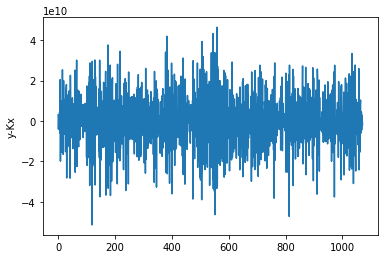

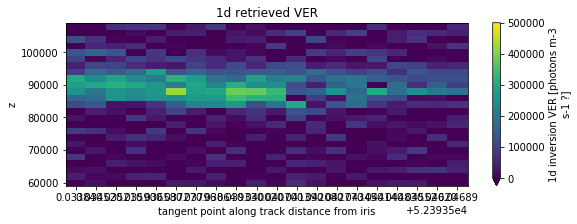

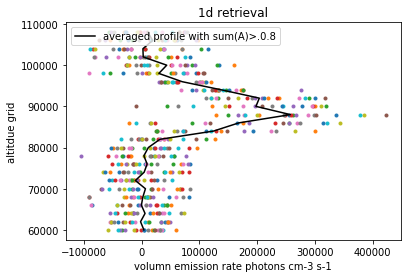

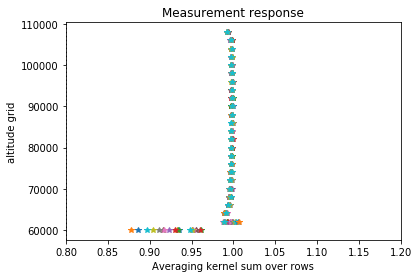

In [118]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(60e3, 110e3, 2e3) # m
z_top = z[-1] + 2e3

result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) *0 # temp
Sa = np.diag(np.ones(len(z)))*(1e7)**2 #temp
#Se = np.diag(np.ones(len(pix_lst))) * (2.5e10)**2# 1e10 #30 #temporary
Ave = []
residual = []
for i in range(len(im_lst)):
    h = tan_alt.isel(mjd=im_lst[i], pixel=tan_alt.pixel[l1.notnull().isel(mjd=im_lst[i])])
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(mjd=im_lst[i], pixel=tan_alt.pixel[l1.notnull().isel(mjd=im_lst[i])]).data
    Se = np.diag(np.ones(len(y))) * (1e12)**2
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 
    residual.extend(y-K.dot(x))


result_1d = xr.DataArray(result_1d, 
                         coords=(mjd[im_lst], z), 
                         dims=('mjd', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
mr_threshold = 0.8
result_1d_mean = result_1d.where(Ave>mr_threshold).mean(dim='mjd')

#==== plot residual
plt.figure()
plt.plot(np.array(residual).ravel())
plt.ylabel('y-Kx')


#==== plot VER contour
#result_1d = abs(result_1d)
result_1d.plot(x='mjd', y='z', 
               #norm=LogNorm(), 
               vmin=0, vmax=5e5, 
               size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='tangent point along track distance from iris')
ax.set_xticks(mjd[im_lst])
#ax.set_xticklabels(np.round(tan_beta.sel(pixel=60).data*Re))
plt.show()

#==== plot VER in 1D
plt.figure()
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with sum(A)>.{}'.format(mr_threshold))
ax.set_xscale('linear')
ax.set(#xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend(loc='upper left')
plt.show()

#==== plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('Averaging kernel sum over rows')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([mr_threshold, 1.2])
plt.axvline(x=mr_threshold, ls=':', color='k')
#plt.text(mr_threshold, z[-1], 'threshold')
plt.show()


# Tomography

In [119]:
from geometry_functions import lla2ecef
import pandas as pd
tan_x, tan_y, tan_z = lla2ecef(tan_lat, tan_lon, tan_alt)
tan_xyz = xr.concat([tan_x, tan_y, tan_z],
                    pd.Index(['x', 'y', 'z'], name='xyz')).transpose('mjd', 'pixel', 'xyz')

norm = np.sqrt((tan_x-sc_pos.sel(xyz='x'))**2 +
                (tan_y-sc_pos.sel(xyz='y'))**2 +
                (tan_z-sc_pos.sel(xyz='z'))**2)

look = (tan_xyz - sc_pos)/norm

sc_look = look
#sc_look = ir.l1.look_ecef

## change coordiante

In [120]:
#====define the new base vectors
n_crosstrack = np.cross(sc_look.isel(mjd=im_lst[0], pixel=60),
                        sc_pos.isel(mjd=im_lst[0]))
n_vel = np.cross(sc_pos.isel(mjd=im_lst[0]), n_crosstrack)
n_zenith = sc_pos.isel(mjd=im_lst[0])

#====tangent points in alpha, beta, rho coordinate
import pandas as pd
from geometry_functions import lla2ecef, cart2sphe, change_of_basis
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

tan_alpha = []
tan_beta = []
tan_rho = []
for i in im_lst:
    p_old = tan_ecef.isel(mjd=i, pixel=pix_lst)
    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z'))
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[mjd[im_lst], pixel[pix_lst]],
                         dims=['mjd', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[mjd[im_lst], pixel[pix_lst]],
                        dims=['mjd', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[mjd[im_lst], pixel[pix_lst]],
                       dims=['mjd', 'pixel'])

Re = 6371 + 100 #Earth radius in km

In [166]:
#len(im_lst)
change_of_basis(n_crosstrack, n_vel, n_zenith, tan_ecef.isel(mjd=im_lst[18], pixel=60))

<xarray.DataArray (xyz: 3)>
array([  45875.263489, 6446744.83764 ,   58175.138401])
Coordinates:
    mjd      float64 5.239e+04
    pixel    int64 60
  * xyz      (xyz) object 'x' 'y' 'z'

<xarray.DataArray (xyz: 3)>
array([ -888082.010783,    83758.723749, -6385089.426544])
Coordinates:
    mjd      float64 5.239e+04
    pixel    int64 60
  * xyz      (xyz) object 'x' 'y' 'z'
Attributes:
    units:    meter

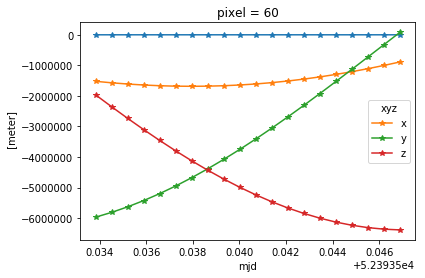

In [144]:
tan_lon.isel(mjd=im_lst, pixel=60).plot(marker='*')
tan_ecef.isel(mjd=im_lst, pixel=60).plot.line(hue='xyz', marker='*')
tan_ecef.isel(mjd=im_lst[-1], pixel=60)

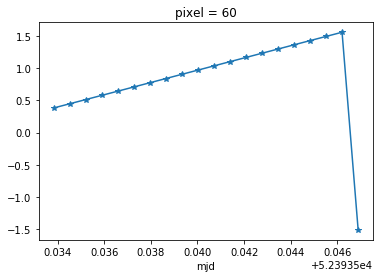

In [128]:
tan_beta.sel(pixel=60).plot(marker='*')

In [122]:
#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.linspace(tan_beta.min()-0.1,
                         tan_beta.max()+0.15, 25) #radian
edges_rho = np.append(z,z_top) # meter
edges = edges_alpha, edges_beta, edges_rho

#====grid points for plotting
grid_alpha = np.append(edges_alpha - np.gradient(edges_alpha)/2, 
                       edges_alpha[-1]+np.gradient(edges_alpha)[-1]/2)
grid_beta = np.append(edges_beta - np.gradient(edges_beta)/2, 
                       edges_beta[-1]+np.gradient(edges_beta)[-1]/2)
grid_rho = np.append(edges_rho - np.gradient(edges_rho)/2, 
                       edges_rho[-1]+np.gradient(edges_rho)[-1]/2)

## Jacobian

In [123]:
#====num of columns & rows of jacobian
col_len = len(grid_alpha) * len(grid_beta) * len(grid_rho)
row_len = l1.isel(mjd=im_lst).notnull().sum().item()

#====measure pathlength in each bin
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look.isel(mjd=image).T)
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos.isel(mjd=image))
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in l1.pixel[l1.notnull().isel(mjd=image)]: 
        #print(image, pix.data, measurement_id)
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))


## Tomo inversion

In [124]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
#y = l1.isel(mjd=im_lst, pixel=pix_lst).data.ravel()
#y[y<0] = 0 #temp
y = l1.isel(mjd=im_lst).stack(msure=('mjd','pixel')).dropna('msure').data
#xa = np.ones(col_len) # temp
xa = interp1d(z, result_1d_mean.data, fill_value='extrapolate')(grid_rho)
xa = np.tile(xa, (len(grid_alpha),len(grid_beta),1)).ravel()
Sa = sp.diags([1], shape=(col_len, col_len)) * (1e7)**2 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id))* (0.8e12)**2 #(5e12)**2 #temp
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

shape_tomo = (len(grid_alpha), len(grid_beta), len(grid_rho))
result_tomo = x_hat.reshape(shape_tomo)
result_tomo = xr.DataArray(result_tomo, 
                           coords=(grid_alpha, grid_beta, grid_rho), 
                           dims=('alpha', 'beta', 'rho')) #temp

A = G.dot(K_coo)
mr_tomo = np.zeros(shape_tomo)
for alpha_id in range(len(grid_alpha)):
    for beta_id in range(len(grid_beta)):
        for rho_id in range(len(grid_rho)):
            grid_id = np.ravel_multi_index((alpha_id, beta_id, rho_id), shape_tomo)
            mr_tomo[alpha_id, beta_id, rho_id] = A[grid_id,:].toarray().squeeze().reshape(shape_tomo).sum()
mr_tomo = xr.DataArray(mr_tomo, coords=result_tomo.coords, dims=result_tomo.dims)


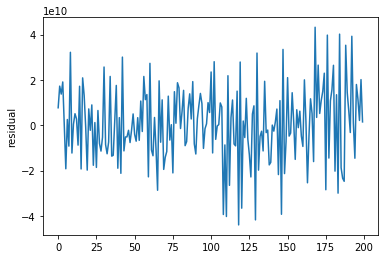

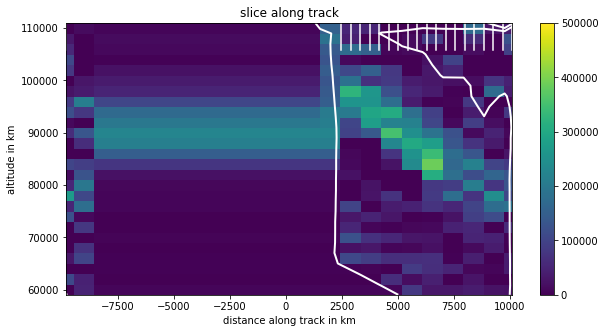

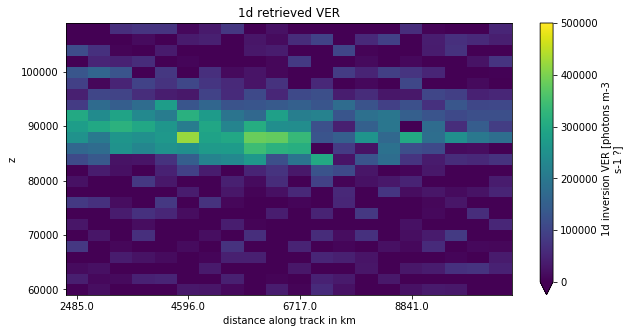

<Figure size 432x288 with 0 Axes>

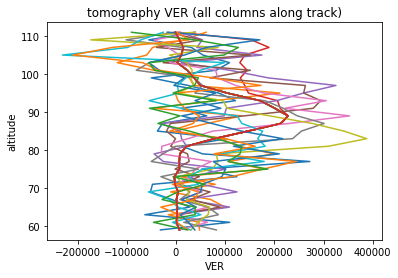

In [125]:
%matplotlib inline
#====check residual
zoom = np.arange(200)
plt.figure()
plt.plot((K_coo.dot(x_hat)-y)[zoom])
plt.ylabel('residual')
plt.show()


#====contour plot 
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.pcolor(grid_beta*Re, grid_rho, result_tomo.isel(alpha=1).T,
          vmin=0, vmax=5e5)#, 
          #size=3, aspect=3)
ax.set(xlabel='distance along track in km',
       ylabel='altitude in km',
       title='slice along track')
plt.colorbar()
for i in range(0,len(im_lst),1):
    plt.axvline(x=tan_beta.sel(pixel=60)[i].data*Re, ymin=0.9, color='w')

plt.contour(grid_beta*Re, grid_rho, mr_tomo.isel(alpha=1).T,
           levels=[0.8, 1.5], colors=('w',), linestyles=('-',),linewidths=(2,))
ax.set(xlim=[(tan_beta.sel(pixel=60)*Re).min(), (tan_beta.sel(pixel=60)*Re).max()])
plt.show()

#====controuf plot from 1d result
plt.figure(figsize=(10,5))
#result_1d = abs(result_1d)
result_1d.plot(x='mjd', y='z', 
               #norm=LogNorm(), 
               vmin=0, vmax=5e5)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='distance along track in km')
ax.set_xticks(mjd[im_lst[::5]])
ax.set_xticklabels(np.round(tan_beta.sel(pixel=60, mjd=mjd[im_lst[::5]]).data*Re))
plt.show()

#==== vertical profiles within the 3D matrix
plt.figure()
fig, ax = plt.subplots()
ax.set_xscale('linear')
ax.set(xlabel='VER',
      ylabel='altitude',
      title='tomography VER (all columns along track)')
for i in range(1,len(grid_alpha)-1):
    for j in range(1, len(grid_beta)-1):
        ax.plot(result_tomo[i,j,:], grid_rho*1e-3, '-')
plt.show()

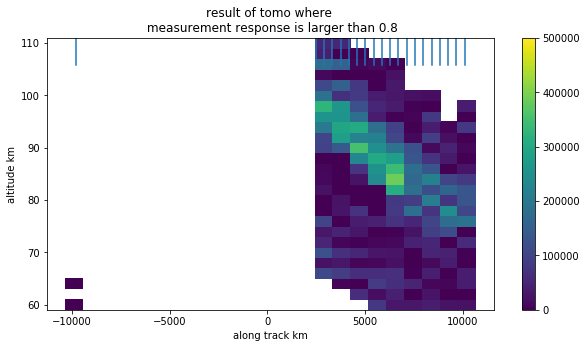

In [126]:
A = G.dot(K_coo)
mr_tomo = np.zeros(shape_tomo)
for alpha_id in range(len(grid_alpha)):
    for beta_id in range(len(grid_beta)):
        for rho_id in range(len(grid_rho)):
            grid_id = np.ravel_multi_index((alpha_id, beta_id, rho_id), shape_tomo)
            mr_tomo[alpha_id, beta_id, rho_id] = A[grid_id,:].toarray().squeeze().reshape(shape_tomo).sum()
mr_tomo = xr.DataArray(mr_tomo, coords=result_tomo.coords, dims=result_tomo.dims)

plt.figure(figsize=(10,5))
plt.pcolor(grid_beta*Re, grid_rho*1e-3, result_tomo.where(mr_tomo>mr_threshold).isel(alpha=1).T,
          vmin=0, vmax=5e5)
plt.xlabel('along track km')
plt.ylabel('altitude km')
plt.title('result of tomo where \n measurement response is larger than {}'.format(mr_threshold))
plt.colorbar()
for i in range(0,len(im_lst),1):
    plt.axvline(x=tan_beta.sel(pixel=60)[i].data*Re, ymin=0.9)


## testing los 

In [31]:
R = 6370e3
sat = 600e3+R
top = 110e3+R
bot = 60e3+R
a = np.sqrt(sat**2 - bot**2) - np.sqrt(top**2-bot**2)
b = np.sqrt(top**2 - bot**2)
start = 1730e3
a_los = start
b_los = start+nop*dl

print(a*1e-3, a_los*1e-3)
print(b*1e-3, b_los*1e-3)

1886.5512662650053 1730.0
803.4301463101817 3230.0
